## **Simple neural network with Pytorch**

In [3]:
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

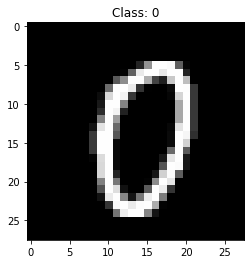

In [5]:
import matplotlib.pyplot as plt
idx = 1000
plt.imshow(train_dataset.data[idx], cmap='gray')
plt.title(f'Class: {train_dataset.targets[idx]}')
plt.show()

In [6]:
train_loader = DataLoader(train_dataset, **{'batch_size': 32})
test_loader = DataLoader(test_dataset, **{'batch_size': 32})

/Users/titipata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


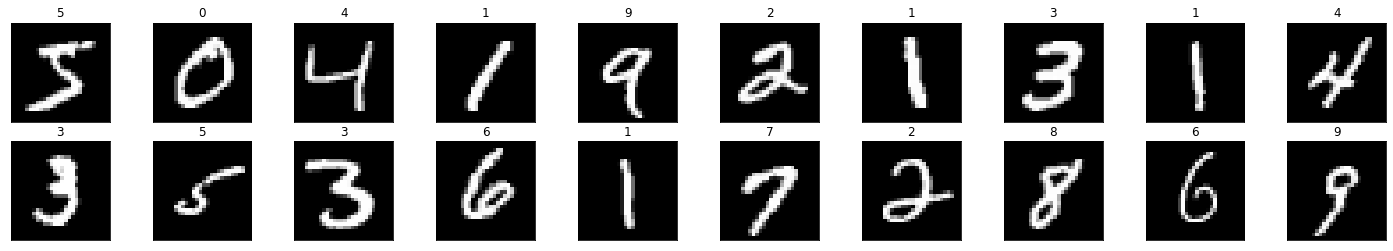

In [10]:
# code from https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

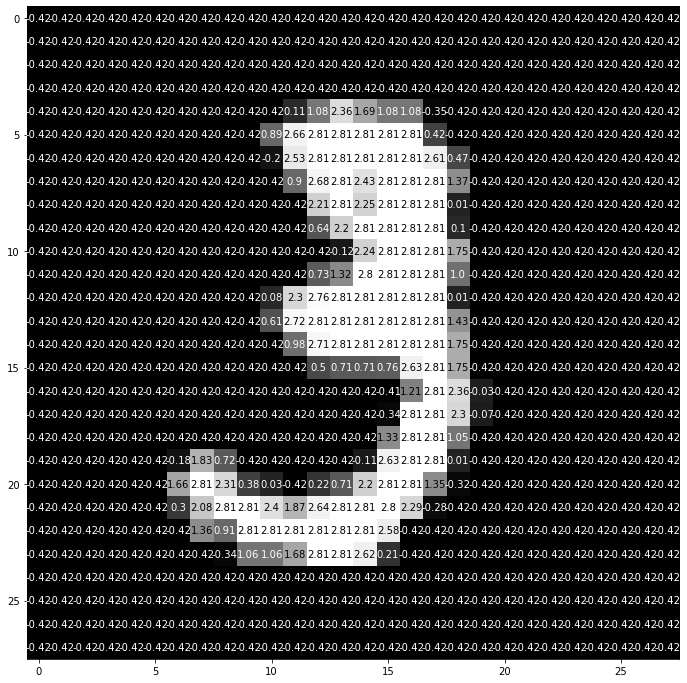

In [12]:
# code from https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/
img = np.squeeze(images[10])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
class OneLayerNN(nn.Module):
    def __init__(self):
        super(OneLayerNN, self).__init__()
        # define layers here
        self.fc = nn.Linear(784, 10)  # fc => fully connected layer, 28 * 28 = 784
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [2]:
torch.manual_seed(126)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check device
model = OneLayerNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # variant of gradient descent algorithm

NameError: name 'torch' is not defined

In [ ]:
model.train()
n_epochs = 1  # change here
for epoch in range(1, n_epochs + 1):
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def predict(input_data):
    logit = model(input_data.unsqueeze(-1))
    y_pred = F.softmax(logit, dim=1).argmax(dim=-1)
    return y_pred

In [ ]:
data, target = next(iter(test_loader))
idx = 3
sample, y = data[idx], target[idx]
plt.imshow(sample.squeeze(0), cmap='gray')
plt.title(f'Actual class: {y}, Predicted class: {predict(sample)[0]}')
plt.show()

In [ ]:
# predict all
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_true.extend(target.tolist())
        y_pred.extend(pred.flatten().tolist())

In [ ]:
print("Accuracy", accuracy_score(y_true, y_pred))
print("Precision, Recall, F1-score", precision_recall_fscore_support(y_true, y_pred, average="macro"))

## **Adding a layer to our neural network**

In [ ]:
class DoubleLayerNN(nn.Module):
    def __init__(self):
        super(DoubleLayerNN, self).__init__()
        # define layers here
        self.fc1 = nn.Linear(784, 100)  # fc => fully connected layer, 28 * 28 = 784
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        logit = F.log_softmax(x, dim=1)
        return logit

In [ ]:
model = DoubleLayerNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.train()
n_epochs = 2  # change here
for epoch in range(1, n_epochs + 1):
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
# predict all
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_true.extend(target.tolist())
        y_pred.extend(pred.flatten().tolist())

In [ ]:
print("Accuracy", accuracy_score(y_true, y_pred))
print("Precision, Recall, F1-score", precision_recall_fscore_support(y_true, y_pred, average="macro"))

## **Convolutional Neural Network (CCN)**

Reference: https://github.com/pytorch/examples/blob/master/mnist/main.py

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
model_cnn = CNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.01)

In [ ]:
model_cnn.train()
n_epochs = 2  # try changing 
for epoch in range(1, n_epochs + 1):
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
# predict all
y_true, y_pred = [], []
model_cnn.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model_cnn(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_true.extend(target.tolist())
        y_pred.extend(pred.flatten().tolist())

In [ ]:
print("Accuracy", accuracy_score(y_true, y_pred))
print("Precision, Recall, F1-score", precision_recall_fscore_support(y_true, y_pred, average="macro"))

## **Transfer learning**

Reference: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb

Download data from [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip)

``` sh
wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
unzip flower_photos.zip
```

In [ ]:
import os.path as op
from torchvision import datasets, models, transforms

In [ ]:
data_dir = '../flower_photos/'
train_dir = op.join(data_dir, 'train/')
test_dir = op.join(data_dir, 'test/')

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

In [ ]:
batch_size = 20
num_workers = 0
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

In [ ]:
vgg16.to(device) # print out model

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
n_inputs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(n_inputs, len(classes))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
vgg16.train()
n_epochs = 2  # try changing 
for epoch in range(1, n_epochs + 1):
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        output = vgg16(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
# predict all
y_true, y_pred = [], []
vgg16.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = vgg16(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_true.extend(target.tolist())
        y_pred.extend(pred.flatten().tolist())

In [ ]:
print("Accuracy", accuracy_score(y_true, y_pred))
print("Precision, Recall, F1-score", precision_recall_fscore_support(y_true, y_pred, average="macro"))

## **Print out example prediction**

In [ ]:
vgg16.to("cpu")  # transfer model back to CPU

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

output = vgg16(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## **Homework**

No writing this week. Run the code and submit writing in PDF format
- CNN: Try changing kernel size in convolutional neural network and rerun the code. Submit your code and prediction scores.
- Transfer learning: Try replacing the model with 2 fully connected layers instead (hint: use [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to add the layers)
- Apply different transforms to data augementation process, put your code and explain if it improves prediction performance
- **Extra 5 points**: Run transfer learning on dog breed classification datasets (https://www.kaggle.com/c/dog-breed-identification/overview), submit and show your results to the class next week